# Face Recognition on a subset of the Labeled Faces in the Wild dataset

In [1]:
%pylab inline

import pylab as pl
import numpy as np

Populating the interactive namespace from numpy and matplotlib


## The LFW dataset

Let's start with downloading the data using a scikit-learn utility function.

In [2]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

Let's introspect the images arrays to find the shapes (for plotting with matplotlib)

In [3]:
X = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names

n_samples, n_features = X.shape
_, h, w = lfw_people.images.shape
n_classes = len(names)

print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))

n_samples: 1288
n_features: 1850
n_classes: 7


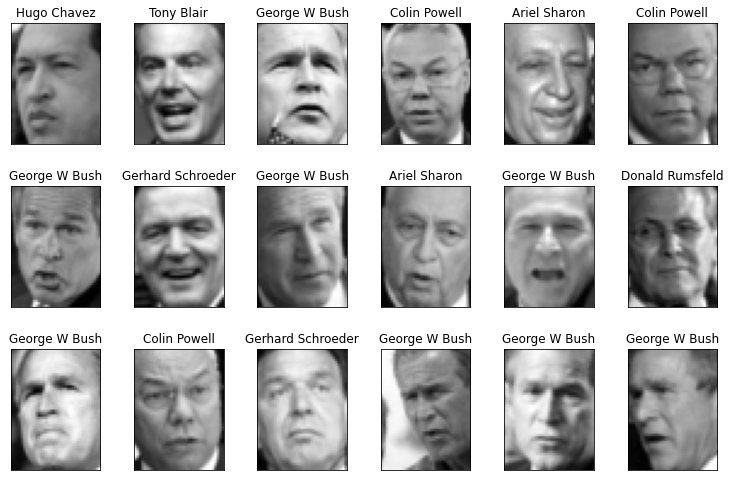

In [4]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())

plot_gallery(X, names[y], h, w)

Let's have a look at the repartition among target classes:

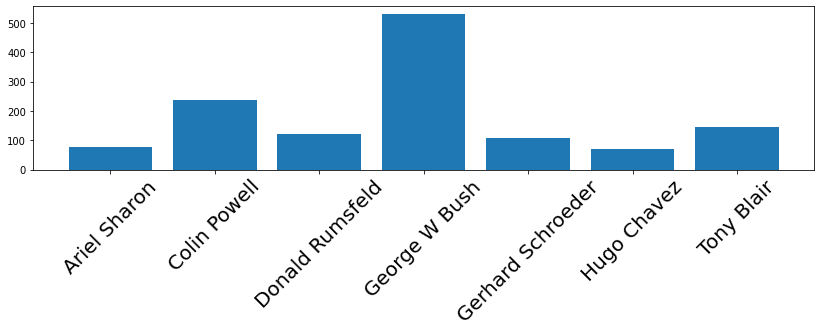

In [5]:
pl.figure(figsize=(14, 3))

y_unique = np.unique(y)
counts = [(y == i).sum() for i in y_unique]

pl.xticks(y_unique,  names[y_unique])
locs, labels = pl.xticks()
pl.setp(labels, rotation=45, size=20)
_ = pl.bar(y_unique, counts)

## Splitting the dataset for model development and then evaluation

Let's split the data in a development set and final evaluation set.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Unsupervised Feature Extraction with Randomized PCA

To train a model we will first reduce the dimensionality of the original picture to a 150 PCA space: unsupervised feature extraction.

In [7]:
from sklearn.decomposition import PCA

n_components = 150

print("Extracting the top %d eigenfaces from %d faces" % (
    n_components, X_train.shape[0]))

pca = PCA(n_components=n_components, whiten=True)

%time pca.fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

Extracting the top 150 eigenfaces from 966 faces
Wall time: 179 ms


Let's plot the gallery of the most significant eigenfaces:

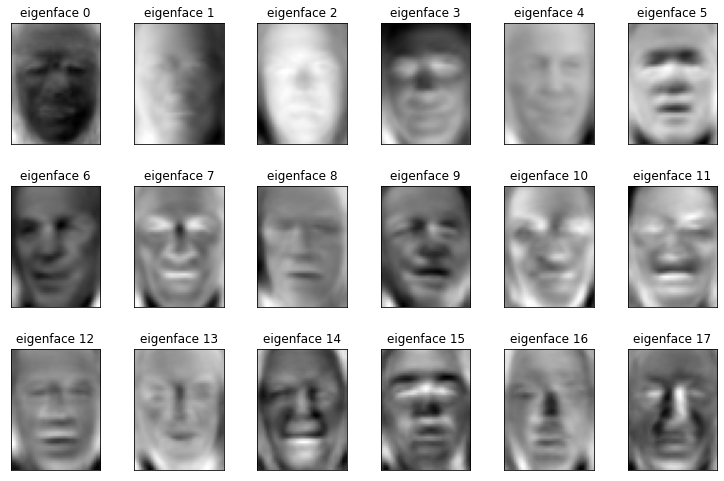

In [8]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

Projecting the input data on the eigenfaces orthonormal basis:

In [9]:
X_train_pca = pca.transform(X_train)

## Training a Gaussian Kernel Support Vector Machine

Let's now train a Kernel Support Vector Machine on the projected data. We perform an automated parameter search to find good values for Gamma and C:

In [10]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', class_weight=None)

svm

SVC()

Unfortunately an SVM is very sensitive to the parameters C and gamma and it's very unlikely that the default parameters will yield a good predictive accurracy:

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score

%time svm_cv_scores = cross_val_score(estimator=svm, X=X_train_pca, y=y_train, cv=2)
svm_cv_scores

Wall time: 141 ms


array([0.58592133, 0.60041408])

In [12]:
svm_cv_scores.mean(), svm_cv_scores.std()

(0.5931677018633541, 0.00724637681159418)

## Data-driven hyper-parameters tuning using a Cross-Validated Grid Search

Fortunately we can automate the search for the best combination of parameters:

In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [5, 5e2, 5e3, 1e4, 5e4, 1e5],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
}

clf = GridSearchCV(svm, param_grid, scoring='balanced_accuracy', cv=2)

In [14]:
%time clf = clf.fit(X_train_pca, y_train)

print("Best estimator found by randomized hyper parameter search:")
print(clf.best_params_)
print("Best parameters validation score: {:.3f}".format(clf.best_score_))

Wall time: 5.1 s
Best estimator found by randomized hyper parameter search:
{'C': 500.0, 'gamma': 0.001}
Best parameters validation score: 0.697


## Final evaluation of the best model on the held-out test set

Let's start with a qualitative inspection of the some of the predictions:

In [15]:
X_test_pca = pca.transform(X_test)
y_pred = clf.predict(X_test_pca)

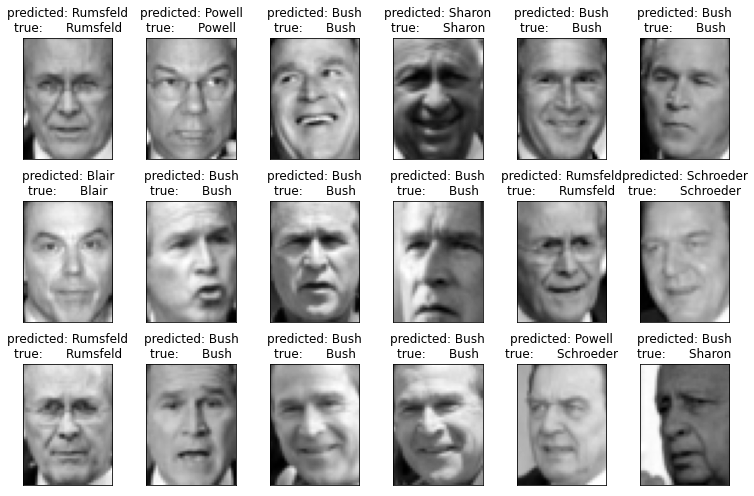

In [16]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.83      0.60      0.70        25
     Colin Powell       0.76      0.86      0.81        58
  Donald Rumsfeld       0.77      0.89      0.83        27
    George W Bush       0.88      0.88      0.88       137
Gerhard Schroeder       0.86      0.73      0.79        26
      Hugo Chavez       0.84      0.89      0.86        18
       Tony Blair       0.89      0.81      0.85        31

         accuracy                           0.84       322
        macro avg       0.83      0.81      0.82       322
     weighted avg       0.84      0.84      0.84       322



In [18]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=range(n_classes))
print(cm)

[[ 15   3   3   4   0   0   0]
 [  0  50   0   7   0   0   1]
 [  0   3  24   0   0   0   0]
 [  3   7   3 121   1   0   2]
 [  0   2   0   2  19   3   0]
 [  0   0   0   2   0  16   0]
 [  0   1   1   2   2   0  25]]


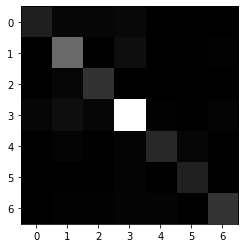

In [19]:
pl.gray()
_ = pl.imshow(cm, interpolation='nearest')